# MouseCortex (STARmap) Analysis Tutorial

<p style="color:#1E90FF;">
<b>Data availability:</b> All processed spatial transcriptomics datasets are publicly available on Zenodo:
<a href="https://doi.org/10.5281/zenodo.17522268" style="color:#1E90FF; text-decoration:underline;">
https://doi.org/10.5281/zenodo.17522268
</a>
</p>

In [1]:
from models.SCILD_main import *
from models.help_func import create_LRDatabase_D
import scanpy as sc
import squidpy as sq
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## Import data

In [2]:
adata = sc.read_h5ad('./data/MouseCortexSTARmap_adata_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 1207 × 1016
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region', 'n_genes'
    var: 'n_cells'
    uns: 'label_colors', 'log1p'
    obsm: 'spatial'

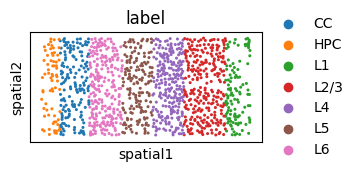

In [3]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.plotting.spatial(adata, color="label", spot_size=200)

## Create L-R database

In [4]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.001,
    database='CellChat',
    species='mouse'
)

In [5]:
LRDatabase_D.shape

(11, 13)

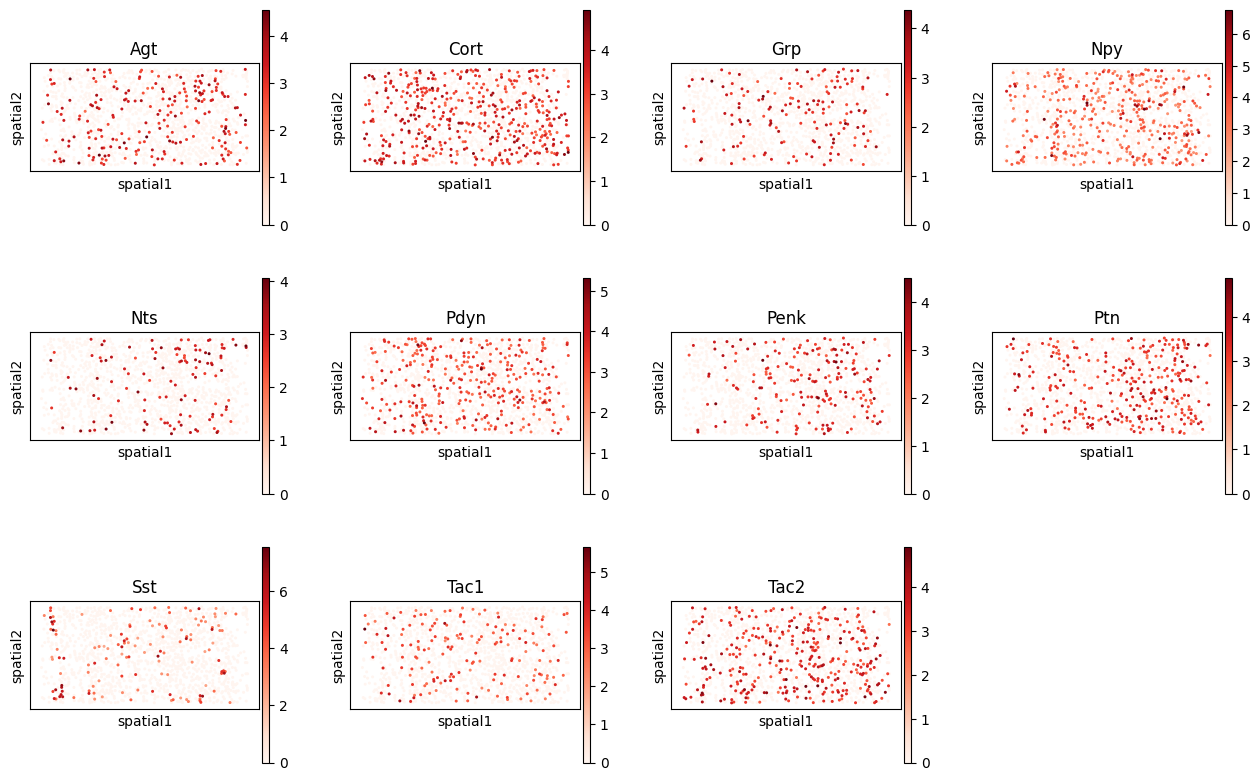

In [6]:
sc.plotting.spatial(adata, color=LRDatabase_D.index, spot_size=200, cmap='Reds')

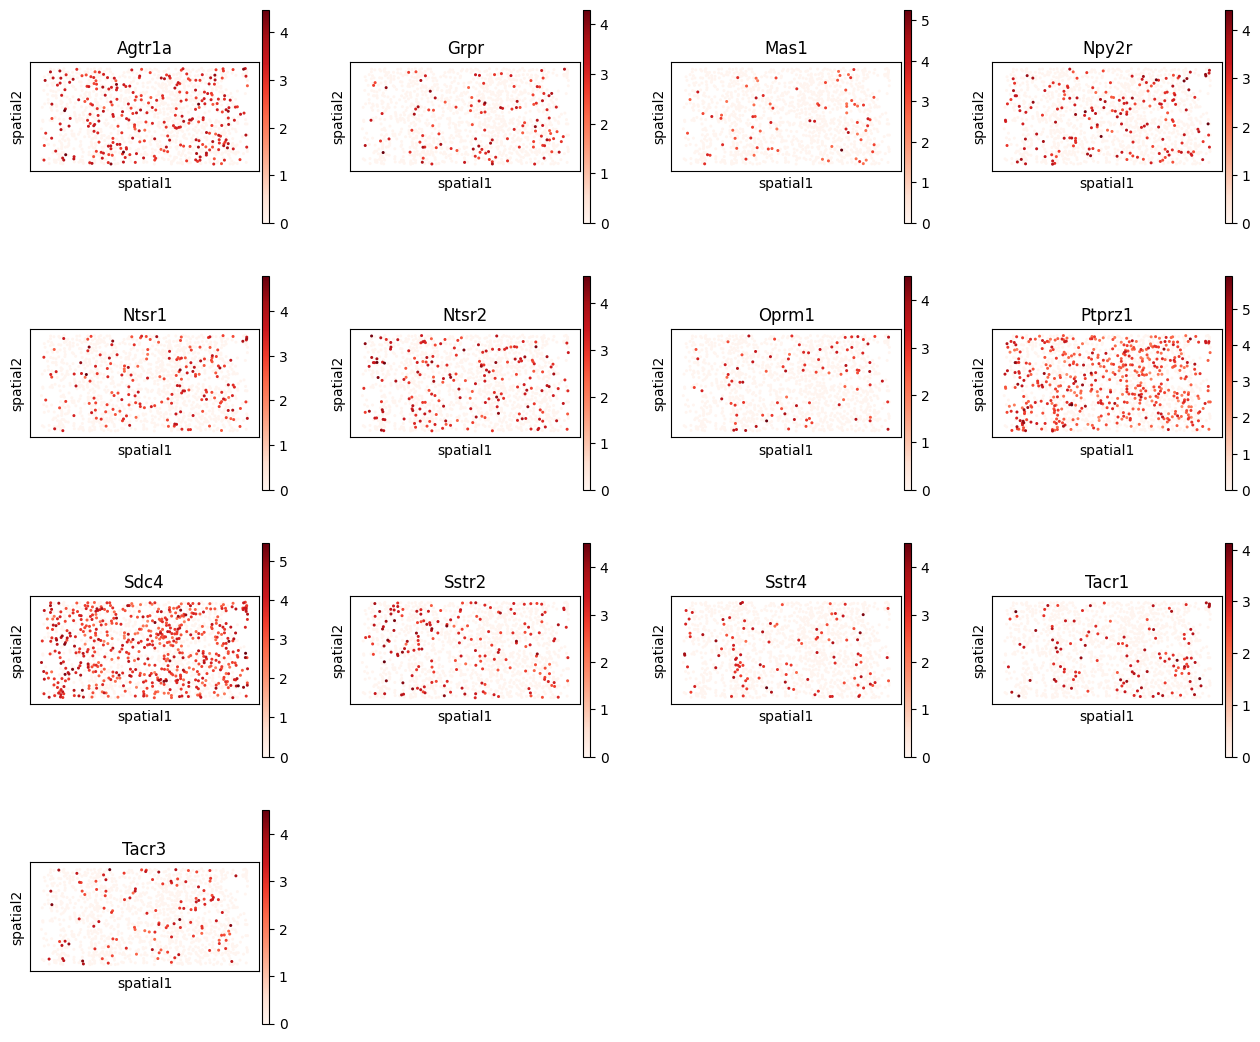

In [7]:
sc.plotting.spatial(adata, color=LRDatabase_D.columns, spot_size=200, cmap='Reds')

## Run SCILD

In [8]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=5,
                alpha_q=0.1,
                alpha_f=0.1,
                alpha_g=0.1,
                niter_max=100,
                eps=1e-4,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 5
The number of ligand is: 11
The number of receptor is: 13
The number of spot is: 1207



*************Solving*************
The relative error is: 0.052271085909753386
The relative error is: 0.026909460993507484
The relative error is: 0.018808243915701947
The relative error is: 0.014696116192999268
The relative error is: 0.012194171283590878
The relative error is: 0.010493618923185195
The relative error is: 0.009253809055894562
The relative error is: 0.008297217631388671
The relative error is: 0.007538483815185315
The relative error is: 0.006908431785006902

 The final relative error is: 0.006908431785006902
The total iteration step is: 100


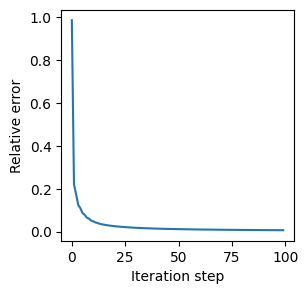

In [9]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [10]:
CCCProb.adata

AnnData object with n_obs × n_vars = 1207 × 1016
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region', 'n_genes'
    var: 'n_cells'
    uns: 'label_colors', 'log1p'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

## Extract LR CCC

In [11]:
CCCProb.query_all_LR()

In [12]:
CCCProb.tensor_P.shape

(1207, 1207, 11, 13)

In [13]:
res_dict = tensor_to_method_result(CCCProb.tensor_P, 
                                   list(CCCProb.LRDatabase_D.index), 
                                   list(CCCProb.LRDatabase_D.columns))
len(res_dict)

143

In [14]:
res_dict = filter_method_result_by_LR_database(res_dict, CCCProb.LRDatabase_D)
len(res_dict)

16

In [15]:
import pickle
with open("./results/MouseCortexSTARmap_SCILD_result.pkl", "wb") as f:
    pickle.dump(res_dict, f)

## Visualization

select L-Rs to show (spatial)

In [16]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 1207 × 32
    obsm: 'spatial'

In [17]:
LR_df_spatial = compute_spatial_autocorrelation(CCC_adata)
LR_df_spatial.sort_values('moran_I', ascending=False).head()

,moran_I,p_value
Cort->Sstr2 (S),0.054677,0.000007
Ptn->Sdc4 (R),0.046113,0.000146
Agt->Mas1 (S),0.035333,0.003434
Nts->Ntsr1 (R),0.034429,0.004333
Cort->Sstr2 (R),0.032446,0.007094


In [18]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,Total_counts,X,Y,label,region,Region,n_genes,Agt->Agtr1a (S),Agt->Agtr1a (R),Agt->Mas1 (S),...,Ptn->Sdc4 (S),Ptn->Sdc4 (R),Sst->Sstr2 (S),Sst->Sstr2 (R),Sst->Sstr4 (S),Sst->Sstr4 (R),Tac1->Tacr1 (S),Tac1->Tacr1 (R),Tac2->Tacr3 (S),Tac2->Tacr3 (R)
Cell_9,310,4923.981189,6385.325072,L6,L6,L6,172,5.414109e-40,4.523904e-41,2.022792e-40,...,6.435828e-36,9.787740e-41,8.167089e-41,1.104392e-40,8.166829e-41,1.127038e-40,5.620536e-33,4.216899e-33,2.644513e-33,1.544943e-20
Cell_10,533,8672.380950,6381.623205,L4,L4,L4,277,4.116200e-42,1.644313e-07,4.117668e-42,...,7.188480e-35,1.113139e+00,8.462995e-39,2.069282e-42,8.462995e-39,2.069051e-42,2.369281e-28,1.409818e-34,2.134403e+00,3.025348e-07
Cell_13,452,11490.769884,6388.780827,L2/3,L2/3,L2/3,237,2.609897e-35,8.247302e-04,2.144022e-42,...,5.502076e-41,4.591599e-11,7.836031e-40,8.373780e-42,1.611859e-38,8.373772e-42,3.817329e-33,3.999034e-19,3.140604e-07,3.320217e-21
Cell_15,288,3224.183789,6397.483509,L6,L6,L6,183,2.307080e-35,3.859754e-09,2.853524e-43,...,1.078730e-36,3.829356e-43,1.316024e-42,7.830919e-44,2.443178e-35,7.826487e-44,5.249070e-36,1.215211e-08,5.360335e-08,3.023774e-20
Cell_16,457,7525.997126,6389.746007,L4,L4,L4,268,2.286463e-04,6.236174e-21,1.340508e-08,...,2.315510e-35,2.315508e-35,3.376019e-35,3.375992e-35,2.977054e-44,1.118231e-44,1.134746e-33,1.728572e-08,2.065144e-34,6.488119e-09


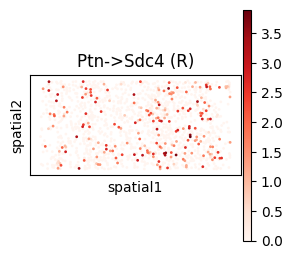

In [19]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=200, color="Ptn->Sdc4 (R)", cmap='Reds', img_key=None)

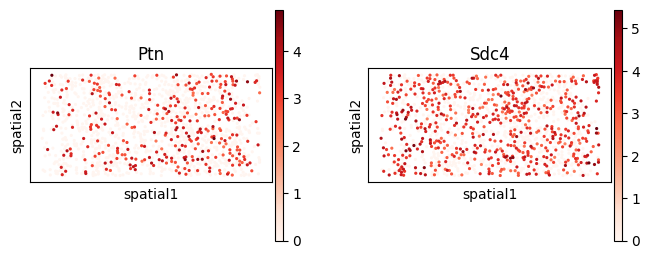

In [20]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=200, color=["Ptn", "Sdc4"], cmap='Reds', img_key=None)

## Cell-group level results

In [21]:
from models.help_func import aggregate_to_group

cell_to_group = adata.obs['label'].to_dict()
group_result = {}
for lr_key, matrix in res_dict.items():
    group_matrix = aggregate_to_group(matrix, cell_to_group)
    group_result[lr_key] = group_matrix.values